<a href="https://colab.research.google.com/github/dangoln/HAR-using-DAGHAR/blob/main/DAGHAR_Final_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#mounting
from google.colab import drive
drive.mount('/content/drive') # Mount to the default /content/drive directory

Mounted at /content/drive


Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, MaxPooling1D, Dropout,
                                     Bidirectional, LSTM, GRU, Dense, GlobalAveragePooling1D,
                                     GaussianNoise, Add, Activation, Lambda)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

Set Seeds and Data Preprocessing

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

data_path = "/content/drive/My Drive/HAR-Datasets/DAGHAR/standardized/RealWorld/RealWorld_waist/"
train_df = pd.read_csv(data_path + "train.csv")
val_df   = pd.read_csv(data_path + "validation.csv")
test_df  = pd.read_csv(data_path + "test.csv")
data_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Select feature columns
feature_columns = [col for col in data_df.columns if col.startswith('accel-') or col.startswith('gyro-')]

def adjust_feature_columns(cols):
    n = len(cols)
    expected = (n // 6) * 6
    if n != expected:
        print(f"Dropping last {n - expected} columns to match a multiple of 6.")
        return cols[:expected]
    return cols

feature_columns = adjust_feature_columns(feature_columns)
num_channels = 6
num_timesteps = len(feature_columns) // num_channels

def reshape_features(df, feature_columns):
    X = df[feature_columns].values
    n_cols = X.shape[1]
    expected = (n_cols // 6) * 6
    if n_cols != expected:
         print(f"Dropping last {n_cols - expected} columns from the data to match a multiple of 6")
         X = X[:, :expected]
    return X.reshape(-1, expected // 6, num_channels)

X = reshape_features(data_df, feature_columns)

# Process labels
label_column = 'standard activity code'
le = LabelEncoder()
y = le.fit_transform(data_df[label_column].values)
num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes)

# Normalize features
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / (std + 1e-8)

Dropping last 2 columns to match a multiple of 6.


Mixup Generator

In [4]:
def mixup_generator(X, y, batch_size=64, alpha=0.2):
    num_samples = X.shape[0]
    while True:
        indices = np.random.permutation(num_samples)
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]
            lam = np.random.beta(alpha, alpha, size=X_batch.shape[0])
            lam = lam.reshape(-1, 1, 1)
            indices_shuffled = np.random.permutation(X_batch.shape[0])
            X_batch_shuffled = X_batch[indices_shuffled]
            y_batch_shuffled = y_batch[indices_shuffled]
            X_mix = lam * X_batch + (1 - lam) * X_batch_shuffled
            lam_labels = lam.reshape(-1, 1)
            y_mix = lam_labels * y_batch + (1 - lam_labels) * y_batch_shuffled
            yield X_mix, y_mix

Hybrid CNN-LSTM-GRU Model with Attention & CV-setup

In [5]:
def build_model():
    # Use the best hyperparameters from previous tuning:
    best_l2_reg = 9.14e-05
    best_dropout_rate = 0.5
    best_num_filters = 128
    best_lstm_units = 128
    best_learning_rate = 1.487e-04

    input_layer = Input(shape=(num_timesteps, num_channels), name="Input")
    x = GaussianNoise(0.1, name="GaussianNoise")(input_layer)

    # CNN Block
    x = Conv1D(filters=best_num_filters, kernel_size=5, padding='same', activation='relu',
               kernel_regularizer=l2(best_l2_reg), name="Conv1D_1")(x)
    x = BatchNormalization(name="BN_1")(x)
    x = Dropout(best_dropout_rate, name="Dropout_1")(x)
    x = Conv1D(filters=best_num_filters, kernel_size=5, padding='same', activation='relu',
               kernel_regularizer=l2(best_l2_reg), name="Conv1D_2")(x)
    x = BatchNormalization(name="BN_2")(x)
    shortcut = Conv1D(filters=best_num_filters, kernel_size=1, padding='same',
                      kernel_regularizer=l2(best_l2_reg), name="Shortcut")(x)
    x = Add(name="Residual")([x, shortcut])
    x = Activation('relu', name="Act")(x)
    x = MaxPooling1D(pool_size=2, name="MaxPool")(x)

    # Hybrid Recurrent Block: LSTM then GRU
    x = Bidirectional(LSTM(best_lstm_units, return_sequences=True,
                           recurrent_regularizer=l2(best_l2_reg)), name="BiLSTM")(x)
    x = Dropout(best_dropout_rate, name="Dropout_LSTM")(x)
    x = Bidirectional(GRU(64, return_sequences=True,
                          recurrent_regularizer=l2(best_l2_reg)), name="BiGRU")(x)
    x = Dropout(best_dropout_rate, name="Dropout_GRU")(x)

    # Attention Mechanism: Compute attention weights for each time step
    attention_scores = Dense(1, activation='tanh', name="Attention_Scores")(x)
    attention_scores = tf.keras.layers.Flatten(name="Attention_Flatten")(attention_scores)
    attention_weights = Activation('softmax', name="Attention_Weights")(attention_scores)
    attention_weights = Lambda(lambda a: tf.expand_dims(a, axis=-1), name="Attention_Expand")(attention_weights)
    attended = Lambda(lambda inputs: inputs[0] * inputs[1], name="Attention_Multiply")([x, attention_weights])
    attended = tf.keras.layers.Lambda(lambda z: tf.reduce_sum(z, axis=1), name="Attention_Sum")(attended)

    # Fully Connected Layers
    x = Dense(128, activation='relu', kernel_regularizer=l2(best_l2_reg), name="FC_1")(attended)
    x = Dropout(best_dropout_rate, name="Dropout_FC")(x)
    output_layer = Dense(num_classes, activation='softmax', name="Output")(x)

    model = Model(inputs=input_layer, outputs=output_layer, name="Hybrid_CNN_LSTM_GRU_Attention")
    optimizer = Adam(learning_rate=best_learning_rate)
    loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
    return model


# Cross-Validation Setup (5-fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
batch_size = 64
epochs = 30

all_train_accuracies = []
all_val_accuracies = []
all_train_losses = []
all_val_losses = []
val_scores = []

fold_no = 1

Training & Evaluation

In [6]:
for train_index, val_index in kf.split(X):
    print(f"\nStarting Fold {fold_no}")
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y_cat[train_index], y_cat[val_index]

    model = build_model()
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]

    steps_per_epoch = X_train_cv.shape[0] // batch_size
    history = model.fit(
        mixup_generator(X_train_cv, y_train_cv, batch_size=batch_size, alpha=0.2),
        steps_per_epoch=steps_per_epoch,
        validation_data=(X_val_cv, y_val_cv),
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    all_train_accuracies.append(history.history['accuracy'])
    all_val_accuracies.append(history.history['val_accuracy'])
    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])

    scores = model.evaluate(X_val_cv, y_val_cv, verbose=0)
    print(f"Fold {fold_no} - Validation Loss: {scores[0]:.4f}, Validation Accuracy: {scores[1]:.4f}")
    val_scores.append(scores[1])
    fold_no += 1


Starting Fold 1
Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.4060 - loss: 1.5807 - val_accuracy: 0.4378 - val_loss: 1.5270
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6285 - loss: 1.2536 - val_accuracy: 0.6969 - val_loss: 1.0759
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6748 - loss: 1.1944 - val_accuracy: 0.7300 - val_loss: 1.0120
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7006 - loss: 1.1569 - val_accuracy: 0.7635 - val_loss: 0.9462
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7033 - loss: 1.1474 - val_accuracy: 0.7449 - val_loss: 0.9847
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7200 - loss: 1.1131 - val_accuracy: 0.7686 - val_loss: 0.9416
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7300 - loss: 1.1110 - val_accuracy: 0.7771 - val_loss: 0.9339
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7377 - loss:

Plots

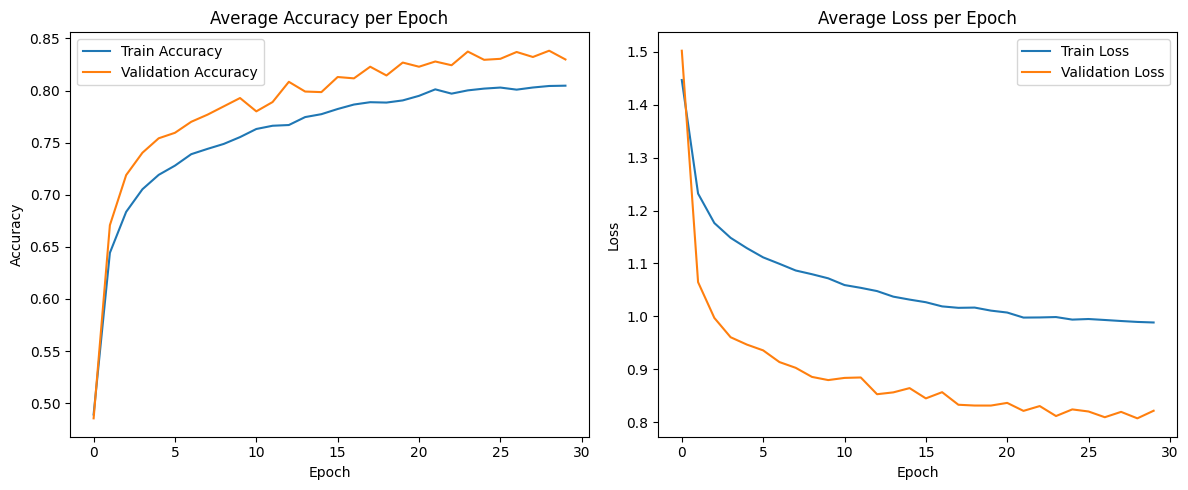


Average Cross-Validation Accuracy: 0.8388


In [7]:
import matplotlib.pyplot as plt

def pad_to_length(lst, length):
    return lst + [lst[-1]] * (length - len(lst))

max_epochs = max(len(hist) for hist in all_train_accuracies)

train_acc_avg = np.mean([pad_to_length(a, max_epochs) for a in all_train_accuracies], axis=0)
val_acc_avg = np.mean([pad_to_length(a, max_epochs) for a in all_val_accuracies], axis=0)
train_loss_avg = np.mean([pad_to_length(l, max_epochs) for l in all_train_losses], axis=0)
val_loss_avg = np.mean([pad_to_length(l, max_epochs) for l in all_val_losses], axis=0)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc_avg, label='Train Accuracy')
plt.plot(val_acc_avg, label='Validation Accuracy')
plt.title('Average Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_avg, label='Train Loss')
plt.plot(val_loss_avg, label='Validation Loss')
plt.title('Average Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Final Output
avg_val_acc = np.mean(val_scores)
print("\nAverage Cross-Validation Accuracy: {:.4f}".format(avg_val_acc))